In [11]:
import lxml.etree as etree

In [23]:
import lxml.etree
import lxml.builder    
import cv2
def make_size(E, width, height, depth):
    DEPTH = E.depth(str(depth))
    WIDTH = E.width(str(width))
    HEIGHT = E.height(str(height)) 
    SIZE = E.size(WIDTH, HEIGHT, DEPTH)
    return SIZE

def make_object(E, name,xmin, ymin,xmax, ymax):
    NAME = E.name(str(name))
    XMIN = E.xmin(str(xmin))
    XMAX = E.xmax(str(xmax))
    YMIN = E.ymin(str(ymin))
    YMAX = E.ymax(str(ymax))   
    BNDBOX = E.bndbox(XMIN, XMAX, YMIN,YMAX)
    OBJECT = E.object(NAME, BNDBOX)
    return OBJECT

def make_annotation(annotation_dict):
    E = lxml.builder.ElementMaker()
    nodes = []
    
    folder = annotation_dict['folder']
    FOLDER = E.folder(folder)
    nodes.append(FOLDER)
    
    filename = annotation_dict['filename']    
    FILENAME = E.filename(filename)
    nodes.append(FILENAME)
    
    size = annotation_dict['size']    
    SIZE = make_size(E, *size)
    nodes.append(SIZE)
    
    objects = annotation_dict['objects']            
    for o in objects:
        name = o['name']
        bbox = o['bbox']
        OBJECT = make_object(E, name, *bbox)
        nodes.append(OBJECT)
        
    ANNOTATION = E.annotation(*nodes)
    return ANNOTATION

import os
def extract_annotation_dict(image_file, label_file):
    objects = []
    image = cv2.imread(image_file)
    size = image.shape
    size = [size[1], size[0], size[2]]
    with open(label_file) as f:
        for line in f:
            line = line.strip()
            o = parse_kitti_annotation(line)
            objects.append(o)
    annotation_dict = {
        'folder': os.path.dirname(image_file),
        'filename': os.path.basename(image_file),
        'size':size,
        'objects': objects
    }
    return annotation_dict, image
"""
1 type Describes the type of object: 'Car', 'Van', 'Truck',
'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
'Misc' or 'DontCare'

1 truncated Float from 0 (non-truncated) to 1 (truncated), where
truncated refers to the object leaving image boundaries

1 occluded Integer (0,1,2,3) indicating occlusion state:
0 = fully visible, 1 = partly occluded
2 = largely occluded, 3 = unknown

1 alpha Observation angle of object, ranging [-pi..pi]

4 bbox 2D bounding box of object in the image (0-based index):
contains left, top, right, bottom pixel coordinates

3 dimensions 3D object dimensions: height, width, length (in meters)
3 location 3D object location x,y,z in camera coordinates (in meters)
1 rotation_y Rotation ry around Y-axis in camera coordinates [-pi..pi]
1 score Only for results: Float, indicating confidence in
detection, needed for p/r curves, higher is better.
"""
def parse_kitti_annotation(line):
    cols = line.split(' ')
    label = cols[0]
    xmin = float(cols[4])
    ymin = float(cols[5])
    xmax = float(cols[6])
    ymax = float(cols[7])
    o = {
        'name': label,
        'bbox': [xmin, ymin, xmax, ymax]
    }
    return o
    

def convert_labels_to_pascal(label_file):
    image_file = label_file.replace('label_2','image_2').replace('txt','png')
    annotation_file = label_file.replace('label_2','Annotations').replace('txt','xml')
    jpg_file = label_file.replace('label_2','JPEGImages').replace('txt','jpg')    
    annotation_dict, image = extract_annotation_dict(image_file, label_file)
    annotation_xml = make_annotation(annotation_dict)
    with open(annotation_file, 'w') as f:
        f.write(etree.tostring(annotation_xml, pretty_print=True))
    cv2.imwrite(jpg_file, image)

In [28]:
import glob
import os
from multiprocessing import Pool
annotations_dirname = 'pascal_voc_annotations_2'
labels_dir  = '/home/blake/nfs/data/kitti/training/label_2/'
labels_files = glob.glob(labels_dir + '*.txt')
annodations_dir = labels_dir.replace('label_2', annotations_dirname)
if not os.path.exists(annodations_dir):
    os.makedirs(annodations_dir)

pool = Pool(processes=48)
done = pool.map(convert_labels_to_pascal, labels_files)
    
    

In [8]:
with open('/sbox/users/blake/datasets/perception/object_detection/2017_03_01_2017_04_26.txt', 'w') as f:
    f.write('\n'.join(per_second_images))

In [2]:
# import embark.pipeline.util.data as data_utils
# config =                         {
#                             "base_folder" : "/sbox/data/",
#                             "sensor_path" : "cameras/cam3/images",
#                             "start_date" : "2017/03/01/01/01/01",
#                             "end_date" : "2017/05/01/01/01/01",
#                             "labels" : {"lanes" : 0.5},
#                             "features" : ["4_lanes", "medium_traffic"]
#                         }

# all_images= data_utils.generate_clip_files(config)

In [6]:
per_second_images = all_images[::10]

In [27]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
label_file ='/sbox/users/blake/data/kitti/training/label_2/000001.txt'
image_file = label_file.replace('label_2', 'JPEGImages').replace('txt', 'jpg')
ad, image = extract_annotation_dict(image_file, label_file)
anno = make_annotation(ad)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for o in ad['objects']:
    xmin, ymin, xmax, ymax = o['bbox']
    print o['bbox']
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,0))
# image = cv2.resize(image, (672, 384))

[599.41, 156.4, 629.75, 189.25]
[387.63, 181.54, 423.81, 203.12]
[676.6, 163.95, 688.98, 193.93]
[503.89, 169.71, 590.61, 190.13]
[511.35, 174.96, 527.81, 187.45]
[532.37, 176.35, 542.68, 185.27]
[559.62, 175.83, 575.4, 183.15]


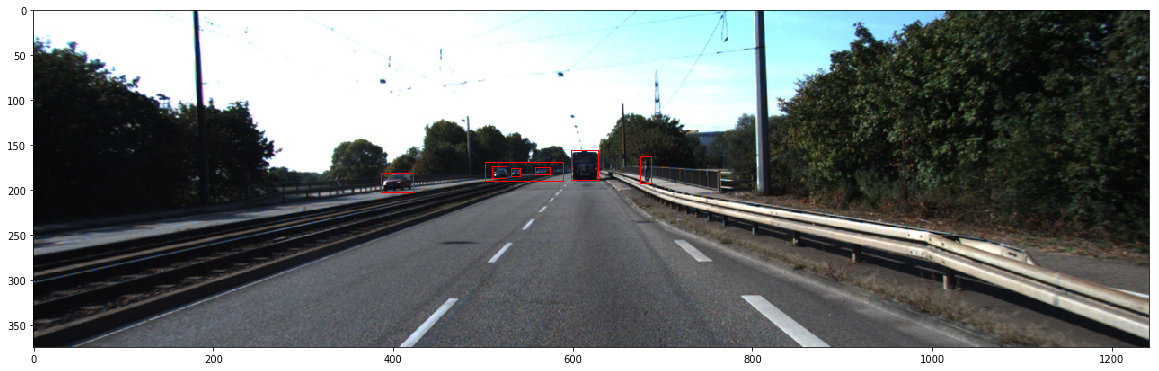

In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(image)

In [25]:
print etree.tostring(anno, pretty_print=True)

<annotation>
  <folder>/sbox/users/blake/data/kitti/training/JPEGImages</folder>
  <filename>000001.jpg</filename>
  <size>
    <width>1242</width>
    <height>375</height>
    <depth>3</depth>
  </size>
  <object>
    <name>Truck</name>
    <bndbox>
      <xmin>599.41</xmin>
      <xmax>629.75</xmax>
      <ymin>156.4</ymin>
      <ymax>189.25</ymax>
    </bndbox>
  </object>
  <object>
    <name>Car</name>
    <bndbox>
      <xmin>387.63</xmin>
      <xmax>423.81</xmax>
      <ymin>181.54</ymin>
      <ymax>203.12</ymax>
    </bndbox>
  </object>
  <object>
    <name>Cyclist</name>
    <bndbox>
      <xmin>676.6</xmin>
      <xmax>688.98</xmax>
      <ymin>163.95</ymin>
      <ymax>193.93</ymax>
    </bndbox>
  </object>
  <object>
    <name>DontCare</name>
    <bndbox>
      <xmin>503.89</xmin>
      <xmax>590.61</xmax>
      <ymin>169.71</ymin>
      <ymax>190.13</ymax>
    </bndbox>
  </object>
  <object>
    <name>DontCare</name>
    <bndbox>
      <xmin>511.35</xmin>
      <xmax

In [20]:
annotation_xml

NameError: name 'annotation_xml' is not defined

In [84]:
    cv2.rectangle?